# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [0]:
import torch

In [0]:
import torch.nn as nn

In [0]:
import torch.optim as optim

In [0]:
import torchvision.datasets as dset

In [0]:
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

In [0]:
from torchvision import transforms

In [0]:
import matplotlib.pyplot as plt

In [0]:
import numpy as np

In [0]:
%matplotlib inline

## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [0]:
# First, lets load the dataset
data_train = dset.SVHN('./data/', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )

In [0]:
data_test = dset.SVHN('./data/', split='test', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [0]:
batch_size = 64

In [0]:
data_size = data_train.data.shape[0]

In [0]:
validation_split = .2

In [0]:
split = int(np.floor(validation_split * data_size))

In [0]:
indices = list(range(data_size))

In [0]:
np.random.shuffle(indices)

In [0]:
train_indices, val_indices = indices[split:], indices[:split]

In [0]:
train_sampler = SubsetRandomSampler(train_indices)

In [0]:
val_sampler = SubsetRandomSampler(val_indices)

In [0]:
train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)

In [0]:
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [0]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

SVHN data sample shape:  torch.Size([3, 32, 32])


In [0]:
# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [0]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10),
         )

In [0]:
nn_model.type(torch.FloatTensor)

Sequential(
  (0): Flattener()
  (1): Linear(in_features=3072, out_features=100, bias=True)
  (2): ReLU(inplace=True)
  (3): Linear(in_features=100, out_features=10, bias=True)
)

In [0]:
# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [0]:
val_loader.batch_size

64

In [0]:
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!
    
    # raise Exception("Not implemented")
    accuracy = 0
    i_step = 0
    for x, y in loader:
        prediction = torch.argmax(model(x), dim=1)
        
        for i in range(len(y)):
            if prediction[i] == y[i]:
                accuracy += 1
            
            i_step += 1
            
    accuracy = accuracy/(i_step)
        
    return accuracy

# compute_accuracy(nn_model, val_loader)

In [0]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history

In [0]:
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

Average loss: 1.821626, Train accuracy: 0.414087, Val accuracy: 0.556549
Average loss: 1.455292, Train accuracy: 0.582210, Val accuracy: 0.600915
Average loss: 1.379176, Train accuracy: 0.617855, Val accuracy: 0.610607


## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [0]:
# Since it's so easy to add layers, let's add some!

# TODO: Implement a model with 2 hidden layers of the size 100

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10),
         )

In [0]:
nn_model.type(torch.FloatTensor)

Sequential(
  (0): Flattener()
  (1): Linear(in_features=3072, out_features=100, bias=True)
  (2): ReLU(inplace=True)
  (3): Linear(in_features=100, out_features=100, bias=True)
  (4): ReLU(inplace=True)
  (5): Linear(in_features=100, out_features=10, bias=True)
)

In [0]:
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.185053, Train accuracy: 0.195014, Val accuracy: 0.210907
Average loss: 2.046432, Train accuracy: 0.249480, Val accuracy: 0.294383
Average loss: 1.871249, Train accuracy: 0.347422, Val accuracy: 0.396969
Average loss: 1.720494, Train accuracy: 0.416579, Val accuracy: 0.425295
Average loss: 1.678058, Train accuracy: 0.433283, Val accuracy: 0.433486


Добавьте слой с Batch Normalization

In [0]:
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d
# 

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 10),
         )

In [0]:
nn_model.type(torch.FloatTensor)

Sequential(
  (0): Flattener()
  (1): Linear(in_features=3072, out_features=100, bias=True)
  (2): ReLU(inplace=True)
  (3): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Linear(in_features=100, out_features=100, bias=True)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Linear(in_features=100, out_features=10, bias=True)
)

In [0]:
optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 1.929461, Train accuracy: 0.372078, Val accuracy: 0.530817
Average loss: 1.518547, Train accuracy: 0.581340, Val accuracy: 0.631015
Average loss: 1.351055, Train accuracy: 0.639423, Val accuracy: 0.660091
Average loss: 1.254884, Train accuracy: 0.668379, Val accuracy: 0.675790
Average loss: 1.190528, Train accuracy: 0.688155, Val accuracy: 0.697495


Добавьте уменьшение скорости обучения по ходу тренировки.

In [0]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

from torch.optim.lr_scheduler import StepLR

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    scheduler = StepLR(optimizer, step_size=2, gamma=0.5)
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value
            
        scheduler.step()

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history

In [0]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 10),
         )

In [0]:
nn_model.type(torch.FloatTensor)

Sequential(
  (0): Flattener()
  (1): Linear(in_features=3072, out_features=100, bias=True)
  (2): ReLU(inplace=True)
  (3): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Linear(in_features=100, out_features=100, bias=True)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Linear(in_features=100, out_features=10, bias=True)
)

In [0]:
optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 1.899885, Train accuracy: 0.393219, Val accuracy: 0.561532
Average loss: 1.463238, Train accuracy: 0.602703, Val accuracy: 0.638796
Average loss: 1.306478, Train accuracy: 0.662048, Val accuracy: 0.676814
Average loss: 1.243316, Train accuracy: 0.681176, Val accuracy: 0.671763
Average loss: 1.189579, Train accuracy: 0.699024, Val accuracy: 0.702614


# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [0]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)

In [0]:
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval() # Evaluation mode
    
    sampler = SubsetSampler(val_indices)
    loader = torch.utils.data.DataLoader(dataset, batch_size=1, 
                                           sampler=sampler)
    
    predictions = []
    ground_truth = []
    for x, y in loader:
        predictions.append(torch.argmax(model(x)))
        ground_truth.append(y)
    
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
    
    #raise Exception("Not implemented")
    
    return np.array(predictions), np.array(ground_truth)

In [0]:
# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, data_train, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

![image.png](attachment:image.png)

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

In [0]:
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    
    confusion_matrix = np.zeros((10,10), np.int)
    
    # TODO: Implement filling the prediction matrix
    for i in range(len(ground_truth)):
        confusion_matrix[predictions[i]][ground_truth[i]] += 1
        
    return confusion_matrix

In [0]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')

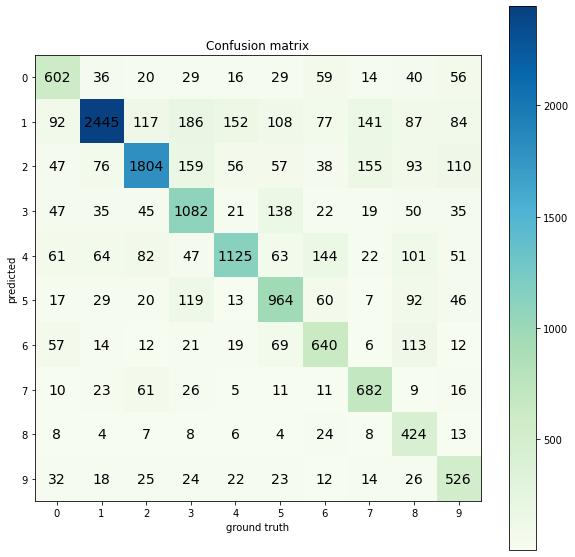

In [0]:
confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

In [0]:
data_train_images = dset.SVHN('./data/', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)

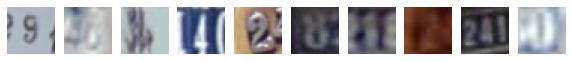

In [0]:
visualize_images(np.array(val_indices[-10:]), data_train_images)

In [0]:
def visualize_predicted_actual(predicted_class, gt_class, predictions, groud_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """

    # TODO: Implement visualization using visualize_images above
    # predictions and ground_truth are provided for validation set only, defined by val_indices
    # Hint: numpy index arrays might be helpful
    # https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays
    # Please make the title meaningful!
    
    ind = []
    
    for i in range(len(predictions)):
        if (predictions[i] == predicted_class) & (groud_truth[i] == gt_class):
            ind.append(val_indices[i])
            
    visualize_images(np.array(ind), data)

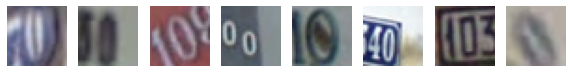

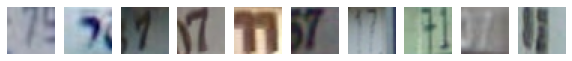

In [0]:
visualize_predicted_actual(8, 0, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 7, predictions, gt, np.array(val_indices), data_train_images)

# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на тестовой выборке должна быть доведена до **80%**

In [0]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, step_size=1, gamma=1):    
    loss_history = []
    train_history = []
    val_history = []
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        
        for i_step, (x, y) in enumerate(train_loader):
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value
            
        scheduler.step()

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history

nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(100),
            nn.Linear(100, 10),
         )

#optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
optimizer = optim.Adam(nn_model.parameters())
loss_history, train_history, val_history = train_model(
                                                        model=nn_model,
                                                        train_loader=train_loader,
                                                        val_loader=val_loader,
                                                        loss=loss,
                                                        optimizer=optimizer,
                                                        num_epochs=30,
                                                        step_size=1,
                                                        gamma=0.9
                                                        )

Average loss: 1.366891, Train accuracy: 0.545234, Val accuracy: 0.681933
Average loss: 0.955286, Train accuracy: 0.696567, Val accuracy: 0.729097
Average loss: 0.837687, Train accuracy: 0.734276, Val accuracy: 0.755716
Average loss: 0.748913, Train accuracy: 0.765195, Val accuracy: 0.757969
Average loss: 0.683891, Train accuracy: 0.785244, Val accuracy: 0.796806
Average loss: 0.635783, Train accuracy: 0.798417, Val accuracy: 0.804450
Average loss: 0.595874, Train accuracy: 0.811845, Val accuracy: 0.804860
Average loss: 0.567015, Train accuracy: 0.822305, Val accuracy: 0.818101
Average loss: 0.530071, Train accuracy: 0.832833, Val accuracy: 0.819739
Average loss: 0.508985, Train accuracy: 0.838327, Val accuracy: 0.826360
Average loss: 0.487888, Train accuracy: 0.847046, Val accuracy: 0.822811
Average loss: 0.464179, Train accuracy: 0.853206, Val accuracy: 0.827793
Average loss: 0.445539, Train accuracy: 0.859264, Val accuracy: 0.829431
Average loss: 0.427905, Train accuracy: 0.864348, V

In [0]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(nn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.8167
